In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os

# For visualization and model building, we'll need more later:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # For splitting data
from sklearn.preprocessing import StandardScaler, MinMaxScaler # For scaling features
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier # Example models
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report # Example metrics
# For time series specific models, you might need:
# from statsmodels.tsa.arima.model import ARIMA
# from prophet import Prophet 
# For deep learning:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

# Set plot style
sns.set_style("whitegrid")

# Define paths
FEATURES_DATA_PATH = "../../data/processed/btc_daily_features.csv"
MODELS_DIR = "models" # Directory to save trained models
MODEL_PATH_PREFIX = os.path.join(MODELS_DIR, "daily_model") # Base path for saving models

# --- Load the feature-engineered data ---
print(f"Loading feature-engineered data from: {FEATURES_DATA_PATH}")
try:
    df_features = pd.read_csv(FEATURES_DATA_PATH, index_col='Date', parse_dates=True)
    print("Feature-engineered data loaded successfully.")
    print(f"DataFrame shape: {df_features.shape}")
except FileNotFoundError:
    print(f"Error: {FEATURES_DATA_PATH} not found. Please ensure the feature engineering step was run and the file exists.")
    df_features = None
except Exception as e:
    print(f"An error occurred loading the feature-engineered data: {e}")
    df_features = None

# Ensure models directory exists
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
    print(f"Created directory: {MODELS_DIR}")

# Display first few rows and info to confirm
if df_features is not None and not df_features.empty:
    print("\n--- First 5 rows of feature-engineered data ---")
    print(df_features.head())
    print("\n--- DataFrame Info ---")
    df_features.info()

Loading feature-engineered data from: ../../data/processed/btc_daily_features.csv
Feature-engineered data loaded successfully.
DataFrame shape: (4008, 23)

--- First 5 rows of feature-engineered data ---
                                 Open        High         Low       Close  \
Date                                                                        
2014-10-06 00:00:00+00:00  320.389008  345.134003  302.559998  330.079010   
2014-10-07 00:00:00+00:00  330.584015  339.247009  320.481995  336.187012   
2014-10-08 00:00:00+00:00  336.115997  354.364014  327.187988  352.940002   
2014-10-09 00:00:00+00:00  352.747986  382.726013  347.687012  365.026001   
2014-10-10 00:00:00+00:00  364.687012  375.066986  352.963013  361.562012   

                             Volume  daily_return       SMA_5       EMA_5  \
Date                                                                        
2014-10-06 00:00:00+00:00  79011800      0.029856  342.807800  341.195946   
2014-10-07 00:00:00+00:00

In [2]:
if df_features is not None and not df_features.empty:
    print("\n--- Defining Target Variable ---")
    # We want to predict the *next* day's return.
    # So, we shift the 'daily_return' column UP by 1 day.
    # This means for a given row (e.g., Day T), the 'target_return' will be Day T+1's return.
    df_features['target_return'] = df_features['daily_return'].shift(-1)
    
    print("Defined 'target_return' (shifted daily return) as the target variable.")
    print("Note: The last row(s) will now have NaN for 'target_return' because there's no future data for them.")
    
    # Display head/tail to show how target is aligned
    print("\nDataFrame head with target:")
    print(df_features[['Close', 'daily_return', 'target_return']].head())
    print("\nDataFrame tail with target:")
    print(df_features[['Close', 'daily_return', 'target_return']].tail())


--- Defining Target Variable ---
Defined 'target_return' (shifted daily return) as the target variable.
Note: The last row(s) will now have NaN for 'target_return' because there's no future data for them.

DataFrame head with target:
                                Close  daily_return  target_return
Date                                                              
2014-10-06 00:00:00+00:00  330.079010      0.029856       0.018505
2014-10-07 00:00:00+00:00  336.187012      0.018505       0.049832
2014-10-08 00:00:00+00:00  352.940002      0.049832       0.034244
2014-10-09 00:00:00+00:00  365.026001      0.034244      -0.009490
2014-10-10 00:00:00+00:00  361.562012     -0.009490       0.002038

DataFrame tail with target:
                                   Close  daily_return  target_return
Date                                                                 
2025-09-21 00:00:00+00:00  115306.093750     -0.003594      -0.022181
2025-09-22 00:00:00+00:00  112748.507812     -0.022181   

In [3]:
if df_features is not None and not df_features.empty:
    print("\n--- Splitting Data Chronologically ---")
    
    # First, remove rows where the target variable is NaN (the last day(s))
    df_features.dropna(subset=['target_return'], inplace=True)
    
    # Define features (X) and target (y)
    # Drop the target variable and any other columns that shouldn't be features
    # 'daily_return' itself might be removed if we're predicting based on *previous* info
    # For now, let's keep it and see, but it's good to be mindful.
    # We'll drop columns like 'target_return' and potentially 'daily_return' itself later if it causes leakage.
    
    # Let's define features first and then select them.
    # Identify columns that are NOT our target or raw price data we don't want as input features
    # We'll remove the current day's close and return, as we want to predict based on PAST info.
    # Also remove any intermediate calculation columns if they exist.
    
    # Feature selection (adjust this list based on your needs)
    # Let's remove the raw prices, current day's return, and the target itself from features
    features_to_exclude = ['Close', 'Open', 'High', 'Low', 'Volume', 'daily_return', 'target_return']
    X = df_features.drop(columns=[col for col in features_to_exclude if col in df_features.columns])
    y = df_features['target_return']
    
    print(f"Features (X) shape: {X.shape}")
    print(f"Target (y) shape: {y.shape}")
    print(f"Features selected: {X.columns.tolist()}")

    # Define split points
    # Example: 70% train, 15% validation, 15% test
    # This split ensures that test data is always from the future relative to train/validation data.
    
    train_size = int(len(df_features) * 0.70)
    val_size = int(len(df_features) * 0.15)
    test_size = len(df_features) - train_size - val_size

    X_train, X_temp = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_temp = y.iloc[:train_size], y.iloc[train_size:]

    X_val, X_test = X_temp.iloc[:val_size], X_temp.iloc[val_size:]
    y_val, y_test = y_temp.iloc[:val_size], y_temp.iloc[val_size:]
    
    print(f"Train set size: {X_train.shape[0]} samples")
    print(f"Validation set size: {X_val.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")

    # Display the date ranges for each split to confirm chronological order
    print("\nDate ranges:")
    print(f"Train: {X_train.index.min().strftime('%Y-%m-%d')} to {X_train.index.max().strftime('%Y-%m-%d')}")
    print(f"Validation: {X_val.index.min().strftime('%Y-%m-%d')} to {X_val.index.max().strftime('%Y-%m-%d')}")
    print(f"Test: {X_test.index.min().strftime('%Y-%m-%d')} to {X_test.index.max().strftime('%Y-%m-%d')}")


--- Splitting Data Chronologically ---
Features (X) shape: (4007, 17)
Target (y) shape: (4007,)
Features selected: ['SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'RSI', 'MACD', 'MACD_Signal', 'Bollinger_Upper', 'Bollinger_Lower', 'OBV', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Return_Lag_1', 'Volume_Lag_1', 'Price_vs_SMA10', 'Volume_vs_Avg_Vol10']
Train set size: 2804 samples
Validation set size: 601 samples
Test set size: 602 samples

Date ranges:
Train: 2014-10-06 to 2022-06-09
Validation: 2022-06-10 to 2024-01-31
Test: 2024-02-01 to 2025-09-24


In [4]:
if X_train is not None and not X_train.empty:
    print("\n--- Scaling Features ---")
    
    # Initialize the scaler
    scaler = StandardScaler() # You can also use MinMaxScaler()
    
    # Fit the scaler ONLY on the training data
    scaler.fit(X_train)
    
    # Transform the training, validation, and test sets
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print("Features scaled using StandardScaler.")
    
    # Convert back to DataFrames for easier handling with model evaluation later
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_val_scaled = pd.DataFrame(X_val_scaled, index=X_val.index, columns=X_val.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)
    
    print("Scaled data converted back to DataFrames.")


--- Scaling Features ---
Features scaled using StandardScaler.
Scaled data converted back to DataFrames.



--- Model Development: Random Forest Regressor ---
Initialized RandomForestRegressor with n_estimators=100, max_depth=10.
Training the model on scaled training data...
Model training complete.

--- Feature Importances ---
Price_vs_SMA10         0.225582
RSI                    0.118816
Return_Lag_1           0.097925
Volume_Lag_1           0.097271
Volume_vs_Avg_Vol10    0.078967
OBV                    0.066268
MACD_Signal            0.066092
MACD                   0.056426
Bollinger_Lower        0.038189
Close_Lag_2            0.029285
Bollinger_Upper        0.028645
SMA_10                 0.024142
Close_Lag_3            0.018545
Close_Lag_1            0.016923
EMA_10                 0.014816
SMA_5                  0.011185
EMA_5                  0.010923
dtype: float64


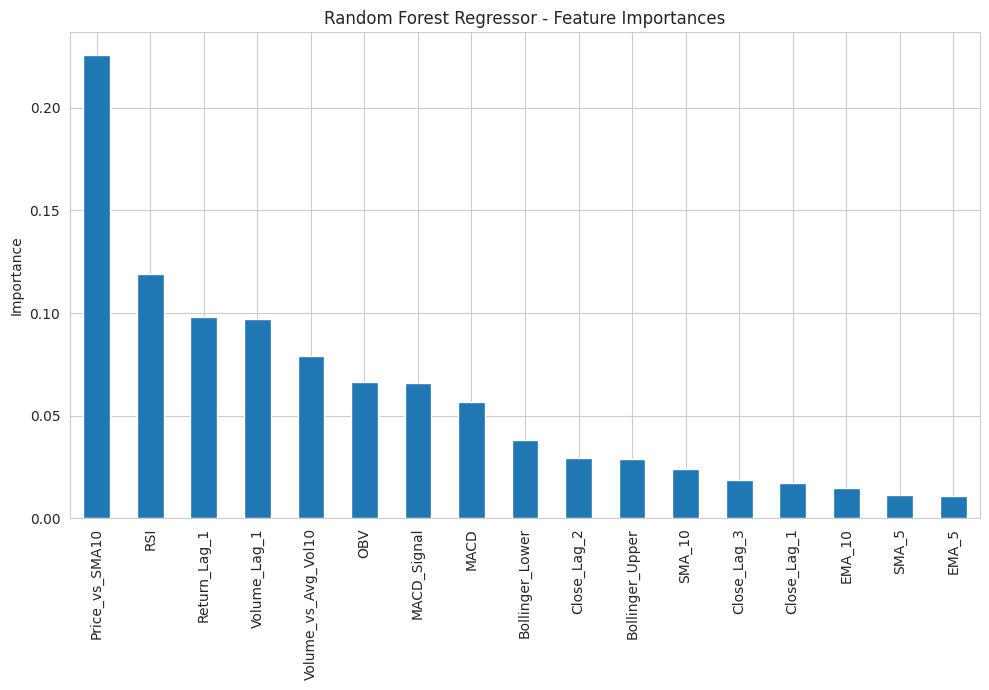

In [5]:
if 'X_train_scaled' in locals() and not X_train_scaled.empty:
    print("\n--- Model Development: Random Forest Regressor ---")
    
    # 1. Model Selection
    # Initialize the RandomForestRegressor
    # n_estimators: number of trees in the forest
    # max_depth: maximum depth of the trees
    # random_state: for reproducibility
    model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1) 
    # n_jobs=-1 uses all available CPU cores for faster training

    print("Initialized RandomForestRegressor with n_estimators=100, max_depth=10.")

    # 2. Model Training
    print("Training the model on scaled training data...")
    model_rf.fit(X_train_scaled, y_train)
    print("Model training complete.")

    # --- Feature Importance ---
    # Random Forests provide feature importances, which can be insightful
    feature_importances = pd.Series(model_rf.feature_importances_, index=X_train.columns)
    print("\n--- Feature Importances ---")
    print(feature_importances.sort_values(ascending=False))

    # Plotting feature importances
    plt.figure(figsize=(10, 7))
    feature_importances.sort_values(ascending=False).plot(kind='bar')
    plt.title('Random Forest Regressor - Feature Importances')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

else:
    print("\nSkipping model training: Scaled training data not found.")


--- Model Prediction and Evaluation ---
Predictions made on validation and test sets.

--- Evaluation Metrics (Test Set) ---
Mean Squared Error (MSE): 0.00077292
Root Mean Squared Error (RMSE): 0.02780143
R-squared (R2) Score: -0.1856


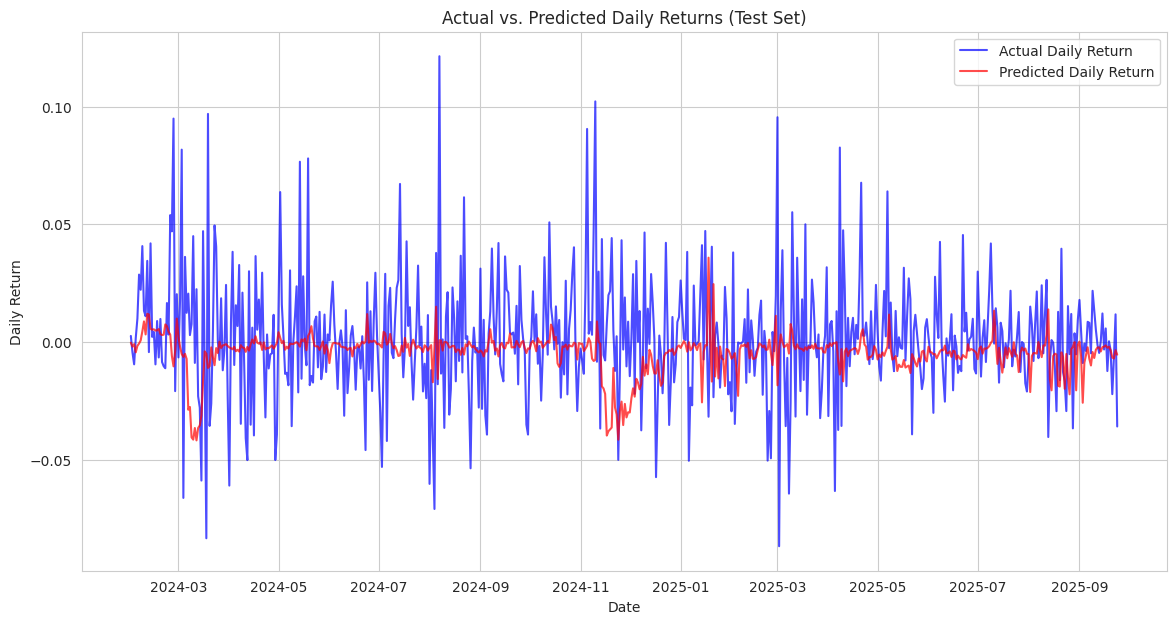


--- Baseline Model (Previous Day's Return) Metrics ---
Baseline MSE: 0.00140631
Baseline RMSE: 0.03750077
Baseline R2 Score: -1.1572

--- Baseline Model (Zero Return) Metrics ---
Baseline Zero MSE: 0.00065542
Baseline Zero RMSE: 0.02560120
Baseline Zero R2 Score: -0.0054


In [6]:
if 'model_rf' in locals() and 'X_test_scaled' in locals():
    print("\n--- Model Prediction and Evaluation ---")

    # 3. Model Prediction
    # Predict on the scaled validation set (useful for hyperparameter tuning, but we'll use test set for final eval)
    y_val_pred = model_rf.predict(X_val_scaled)
    
    # Predict on the scaled test set
    y_test_pred = model_rf.predict(X_test_scaled)
    print("Predictions made on validation and test sets.")

    # 4. Model Evaluation (Regression Metrics)
    print("\n--- Evaluation Metrics (Test Set) ---")
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_test_pred)
    print(f"Mean Squared Error (MSE): {mse:.8f}")

    # Root Mean Squared Error (RMSE) - often more interpretable than MSE
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse:.8f}")

    # R-squared (R2) Score - proportion of variance explained by the model
    r2 = r2_score(y_test, y_test_pred)
    print(f"R-squared (R2) Score: {r2:.4f}")
    
    # You can also evaluate on the validation set if you were tuning hyperparameters
    # mse_val = mean_squared_error(y_val, y_val_pred)
    # rmse_val = np.sqrt(mse_val)
    # r2_val = r2_score(y_val, y_val_pred)
    # print(f"\nValidation Set Metrics: MSE={mse_val:.8f}, RMSE={rmse_val:.8f}, R2={r2_val:.4f}")

    # --- Visualizing Predictions vs. Actual ---
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual Daily Return', color='blue', alpha=0.7)
    plt.plot(y_test.index, y_test_pred, label='Predicted Daily Return', color='red', alpha=0.7)
    plt.title('Actual vs. Predicted Daily Returns (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.show()

    # --- Compare with a simple baseline ---
    # What if we just predicted the previous day's return? (Lagged Return Feature)
    # Or what if we predict 0 return every day?
    baseline_return = y_test.shift(1).fillna(0) # Previous day's actual return as prediction
    baseline_mse = mean_squared_error(y_test, baseline_return)
    baseline_rmse = np.sqrt(baseline_mse)
    baseline_r2 = r2_score(y_test, baseline_return)
    print("\n--- Baseline Model (Previous Day's Return) Metrics ---")
    print(f"Baseline MSE: {baseline_mse:.8f}")
    print(f"Baseline RMSE: {baseline_rmse:.8f}")
    print(f"Baseline R2 Score: {baseline_r2:.4f}")

    # A very simple baseline: always predict 0 return
    baseline_zero_mse = mean_squared_error(y_test, np.zeros(len(y_test)))
    baseline_zero_rmse = np.sqrt(baseline_zero_mse)
    baseline_zero_r2 = r2_score(y_test, np.zeros(len(y_test)))
    print("\n--- Baseline Model (Zero Return) Metrics ---")
    print(f"Baseline Zero MSE: {baseline_zero_mse:.8f}")
    print(f"Baseline Zero RMSE: {baseline_zero_rmse:.8f}")
    print(f"Baseline Zero R2 Score: {baseline_zero_r2:.4f}")

else:
    print("\nSkipping prediction and evaluation: Model or test data not available.")

In [7]:
if 'X_train_scaled' in locals() and not X_train_scaled.empty:
    print("\n--- Preparing Data for LSTM ---")

    # LSTM requires data in the shape (samples, timesteps, features)
    # samples: number of sequences
    # timesteps: length of each sequence (lookback window)
    # features: number of input features at each timestep

    # Let's define a lookback window (e.g., 60 days)
    lookback_window = 60 
    
    # We need to create sequences from the scaled data
    # Function to create sequences
    def create_sequences(data, target, lookback):
        X, y = [], []
        for i in range(len(data) - lookback):
            # Feature sequence: data[i:(i + lookback)]
            X.append(data[i:(i + lookback)])
            # Target: the value we want to predict AFTER the sequence ends
            y.append(target[i + lookback]) 
        return np.array(X), np.array(y)

    # Apply the function to training, validation, and test sets
    # We need to use the SCALED data for training/validation/testing features
    # but the ORIGINAL target variable (y_train, y_val, y_test)
    
    X_train_lstm, y_train_lstm = create_sequences(X_train_scaled.values, y_train.values, lookback_window)
    X_val_lstm, y_val_lstm = create_sequences(X_val_scaled.values, y_val.values, lookback_window)
    X_test_lstm, y_test_lstm = create_sequences(X_test_scaled.values, y_test.values, lookback_window)

    print(f"Original scaled train data shape: {X_train_scaled.shape}")
    print(f"LSTM train sequences shape: {X_train_lstm.shape}") # (samples, timesteps, features)
    print(f"LSTM train targets shape: {y_train_lstm.shape}") # (samples,)

    print(f"LSTM validation sequences shape: {X_val_lstm.shape}")
    print(f"LSTM validation targets shape: {y_val_lstm.shape}")

    print(f"LSTM test sequences shape: {X_test_lstm.shape}")
    print(f"LSTM test targets shape: {y_test_lstm.shape}")

else:
    print("\nSkipping LSTM data preparation: Scaled training data not available.")


--- Preparing Data for LSTM ---
Original scaled train data shape: (2804, 17)
LSTM train sequences shape: (2744, 60, 17)
LSTM train targets shape: (2744,)
LSTM validation sequences shape: (541, 60, 17)
LSTM validation targets shape: (541,)
LSTM test sequences shape: (542, 60, 17)
LSTM test targets shape: (542,)


In [8]:
# Check if TensorFlow is installed (pip install tensorflow or tensorflow-cpu)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    print("\nTensorFlow/Keras found. Proceeding with LSTM model definition.")

    # Check if data is prepared for LSTM
    if 'X_train_lstm' in locals() and X_train_lstm.shape[0] > 0:
        # Get dimensions for LSTM input
        num_samples_train, num_timesteps, num_features = X_train_lstm.shape
        num_samples_val, _, _ = X_val_lstm.shape # Use validation shape for its length
        num_samples_test, _, _ = X_test_lstm.shape

        # Define LSTM model
        lstm_model = Sequential()

        # Add LSTM layers
        # LSTM layer 1
        lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(num_timesteps, num_features)))
        lstm_model.add(Dropout(0.2)) # Dropout for regularization

        # LSTM layer 2
        lstm_model.add(LSTM(units=50, return_sequences=True))
        lstm_model.add(Dropout(0.2))

        # LSTM layer 3 (last LSTM layer before Dense layer, so return_sequences=False)
        lstm_model.add(LSTM(units=50, return_sequences=False))
        lstm_model.add(Dropout(0.2))

        # Dense output layer
        # For regression, we use a single Dense unit with a linear activation (default)
        lstm_model.add(Dense(units=1))

        # Compile the model
        lstm_model.compile(optimizer='adam', loss='mean_squared_error') # MSE is common for regression

        print("\nLSTM Model Summary:")
        lstm_model.summary()

    else:
        print("\nSkipping LSTM model definition: LSTM data not prepared.")

except ImportError:
    print("\nTensorFlow/Keras not found. Please install TensorFlow ('pip install tensorflow' or 'pip install tensorflow-cpu') to use LSTM models.")
    lstm_model = None # Ensure lstm_model is None if TF is not found

2025-09-25 22:40:33.468263: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-25 22:40:33.474128: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-25 22:40:33.926192: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-25 22:40:35.497883: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur


TensorFlow/Keras found. Proceeding with LSTM model definition.

LSTM Model Summary:


2025-09-25 22:40:35.847508: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/valid-result/Documents/GitHub/Bitcoin-Daily-Navigator/Bitcoin-Daily-Navigator/.venv/lib64/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        13,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,051 (211.14 KB)

 Trainable params: 54,051 (211.14 KB)

 Non-trainable params: 0 (0.00 B)


--- Training LSTM Model ---
Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0034 - val_loss: 7.0751e-04
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0019 - val_loss: 7.8589e-04
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0018 - val_loss: 6.7468e-04
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0017 - val_loss: 7.3333e-04
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0017 - val_loss: 6.8131e-04
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0017 - val_loss: 6.8292e-04
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0016 - val_loss: 6.9973e-04
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0016 - val_loss: 6.4039e-04
Epoch 9/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0016 - val_loss: 6.5551e-04
Epoch 10/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0016 - val_loss: 6.3323e-04
Epoch 11/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0016 - val_loss: 6

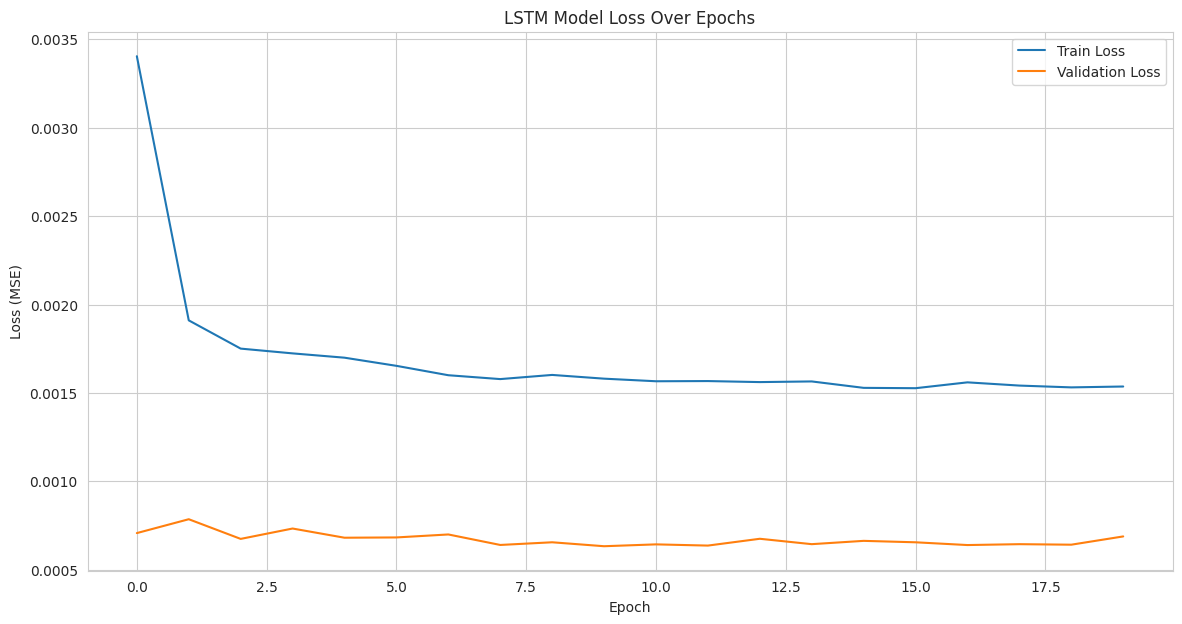

In [9]:
# Check if model and data are ready
if 'lstm_model' in locals() and lstm_model is not None and 'X_train_lstm' in locals() and X_train_lstm.shape[0] > 0:
    print("\n--- Training LSTM Model ---")

    # Early Stopping to prevent overfitting and save training time
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = lstm_model.fit(
        X_train_lstm, y_train_lstm,
        epochs=50, # Number of training passes over the dataset
        batch_size=32, # Number of samples per gradient update
        validation_data=(X_val_lstm, y_val_lstm), # Use validation set to monitor performance
        callbacks=[early_stopping],
        verbose=1 # Set to 1 to show training progress
    )

    print("LSTM Model training complete.")

    # --- Plot Training History ---
    plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

else:
    print("\nSkipping LSTM training: Model or prepared LSTM data not available.")


--- Predicting and Evaluating LSTM Model ---
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predictions made on LSTM test set.

--- Evaluation Metrics (LSTM Test Set) ---
LSTM MSE: 0.00070569
LSTM RMSE: 0.02656481
LSTM R2 Score: -0.1795

--- Comparison with Other Models (Test Set RMSE) ---
Baseline (Prev Day Return) RMSE: 0.03750077
Baseline (Zero Return) RMSE: 0.02560120
Random Forest Regressor RMSE: 0.02780143
LSTM Model RMSE: 0.02656481


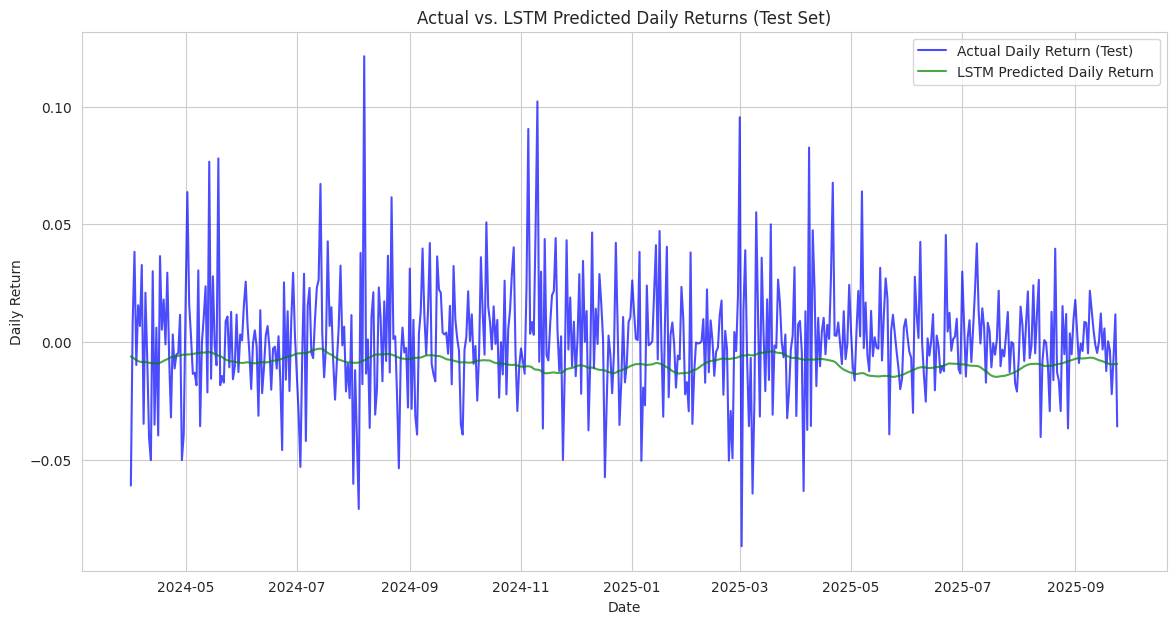

In [11]:
# Check if model and data are ready for prediction and evaluation
if 'lstm_model' in locals() and lstm_model is not None and 'X_test_lstm' in locals() and X_test_lstm.shape[0] > 0:
    print("\n--- Predicting and Evaluating LSTM Model ---")

    # Make predictions on the test set
    y_test_pred_lstm = lstm_model.predict(X_test_lstm)

    # IMPORTANT: The 'predict' method might return a 2D array.
    # We need to ensure we're comparing apples to apples with y_test_lstm.
    # If y_test_pred_lstm is shape (n_samples, 1), flatten it.
    if y_test_pred_lstm.shape[1] == 1:
        y_test_pred_lstm = y_test_pred_lstm.flatten()

    print("Predictions made on LSTM test set.")

    # --- Evaluation Metrics (Regression) ---
    print("\n--- Evaluation Metrics (LSTM Test Set) ---")
    
    # Ensure y_test_lstm is also in the correct shape if needed (usually it's (n_samples,))
    # If y_test_lstm was also created as a 2D array, flatten it.
    # This depends on how y_test_lstm was created in `create_sequences`.
    # Assuming y_test_lstm is already 1D from create_sequences.

    # MSE
    mse_lstm = mean_squared_error(y_test_lstm, y_test_pred_lstm)
    print(f"LSTM MSE: {mse_lstm:.8f}")

    # RMSE
    rmse_lstm = np.sqrt(mse_lstm)
    print(f"LSTM RMSE: {rmse_lstm:.8f}")

    # R-squared
    r2_lstm = r2_score(y_test_lstm, y_test_pred_lstm)
    print(f"LSTM R2 Score: {r2_lstm:.4f}")
    
    # --- Compare with Baseline Models (for context) ---
    # Assuming baseline metrics (rmse, baseline_rmse, baseline_zero_rmse) were calculated previously
    # and RF metrics (rmse, r2) were also calculated.
    print("\n--- Comparison with Other Models (Test Set RMSE) ---")
    # You'll need to retrieve the baseline and RF RMSE values calculated earlier if they weren't saved/printed here.
    # For clarity, let's re-print or assume they are available.
    # If not printed/saved, you'd re-calculate them here on the test set.
    # Let's assume `rmse` is RF's RMSE and `baseline_rmse` and `baseline_zero_rmse` are the baseline RMSEs.
    print(f"Baseline (Prev Day Return) RMSE: {baseline_rmse:.8f}") 
    print(f"Baseline (Zero Return) RMSE: {baseline_zero_rmse:.8f}")
    print(f"Random Forest Regressor RMSE: {rmse:.8f}") # Assuming `rmse` variable from RF section is available
    print(f"LSTM Model RMSE: {rmse_lstm:.8f}")

    # --- Visualizing Predictions vs. Actual ---
    # The dates for LSTM predictions are shifted due to sequence creation.
    # We need to align them correctly with the original test set dates.
    # The prediction y_test_pred_lstm[i] corresponds to the target_return at index (lookback_window + i) in the original df_features.
    # So, the dates should correspond to the test set dates starting from the (lookback_window)-th sample.
    
    # Get the dates corresponding to the y_test_lstm predictions
    # Ensure y_test_lstm is aligned with y_test dates.
    # y_test_lstm[i] corresponds to y_test[lookback_window + i]
    
    # Correct date alignment for plotting LSTM predictions
    # Need to make sure y_test and y_test_lstm are correctly sized and aligned.
    # The number of samples for LSTM test data (y_test_lstm) will be len(y_test) - lookback_window.
    # So, we need to slice y_test accordingly.
    
    # Get the index for the test set predictions
    # The first prediction corresponds to the data point at index `lookback_window` in the original `df_features` after dropping NaNs for target.
    # So, it corresponds to `y_test`'s index at `lookback_window` offset.
    lstm_prediction_dates = y_test.index[lookback_window:] 
    
    # Ensure the lengths match before plotting
    if len(lstm_prediction_dates) == len(y_test_lstm) == len(y_test_pred_lstm):
        plt.figure(figsize=(14, 7))
        # Plot actual values for the aligned period
        plt.plot(lstm_prediction_dates, y_test_lstm, label='Actual Daily Return (Test)', color='blue', alpha=0.7)
        # Plot predicted values
        plt.plot(lstm_prediction_dates, y_test_pred_lstm, label='LSTM Predicted Daily Return', color='green', alpha=0.7)
        plt.title('Actual vs. LSTM Predicted Daily Returns (Test Set)')
        plt.xlabel('Date')
        plt.ylabel('Daily Return')
        plt.legend()
        plt.show()
    else:
        print("Warning: Date alignment for LSTM prediction visualization failed due to length mismatch.")
        print(f"Dates length: {len(lstm_prediction_dates)}, y_test_lstm length: {len(y_test_lstm)}, y_test_pred_lstm length: {len(y_test_pred_lstm)}")
        print("LSTM prediction visualization skipped.")


else:
    print("\nSkipping LSTM prediction and evaluation: Model or prepared LSTM test data not available.")